In [1]:
#import essential libraries 
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torchvision import models
import os
import pandas as pd
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import time
import copy
from tqdm import tqdm
import numpy as np
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import pdb

In [2]:
#%automatic reloading during training
%load_ext autoreload
%autoreload 2

In [3]:
# set seed for  reproduciblity of the code
random_seed = 2023 # or any of your favorite number 
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

In [4]:
# Set the device, check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
#define a custom class from my dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = {'MS': 1, 'noMS': 0}
        self.data = self.load_data()
        random.shuffle(self.data)  # Shuffle the data upon initialization

    def load_data(self):
        data = []

        for class_name, class_label in self.classes.items():
            class_path = os.path.join(self.root_dir, class_name)

            for filename in os.listdir(class_path):
                if filename.endswith(".jpg"):
                    img_path = os.path.join(class_path, filename)
                    data.append((img_path, class_label))

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust the size as needed
    transforms.ToTensor(),
])
dataset = CustomDataset(root_dir='C:\\Users\\hajami\\Desktop\\535-data', transform=transform)

In [7]:
#split the dataset 
from torch.utils.data import random_split

# Split the dataset into train, validation, and test sets
train_size = int(0.70 * len(dataset))
val_size = int(0.20 * len(dataset))
test_size = len(dataset) - train_size - val_size  # Corrected calculation

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

# Access the individual datasets
print(len(train_data))  # Number of samples in the training set
print(len(val_data))    # Number of samples in the validation set
print(len(test_data))   # Number of samples in the test set

21420
6120
3060


In [8]:
#define the dataloader for training and testing loops
from torch.utils.data import DataLoader

train_len = len(train_data)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

val_len = len(val_data)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=True)

test_len = len(test_data)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

data_loaders = {'train':train_dataloader, 'val':val_dataloader}

In [9]:
classes = train_data.dataset.classes

In [10]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


In [11]:
print(torch.cuda.is_available())

True


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [13]:
train_loss =  []
train_acc = []
val_loss = []
val_acc = []
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(train_dataloader)
    val_batches = len(val_dataloader)
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        model.train(True)
        
        for data in tqdm(train_dataloader):
            
                
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
        
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train / train_len
        avg_acc = acc_train / train_len
        train_loss.append(avg_loss)
        train_acc.append(avg_acc)
        
        model.train(False)
        model.eval()
            
        for data in tqdm(val_dataloader):
                
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.item()
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / val_len
        avg_acc_val = acc_val / val_len
        
        val_loss.append(avg_loss_val)
        val_acc.append(avg_acc_val)
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())
        
        #scheduler.step(avg_loss_val)
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [14]:
train_len, val_len, test_len

(21420, 6120, 3060)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models

# Assuming device is already defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# Modify the fully connected layer to output 2 classes
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier[6].parameters():
    param.requires_grad = True

# Move model to device
model.to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.3)


In [18]:
train_model(model, criterion, optimizer, scheduler, num_epochs=40)

Epoch 0/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:24<00:00,  7.89it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:24<00:00,  7.91it/s]



Epoch 0 result: 
Avg loss (train): 0.0177
Avg acc (train): 0.7106
Avg loss (val): 0.0146
Avg acc (val): 0.8225
----------

Epoch 1/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  8.00it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:24<00:00,  7.97it/s]



Epoch 1 result: 
Avg loss (train): 0.0150
Avg acc (train): 0.7774
Avg loss (val): 0.0133
Avg acc (val): 0.8353
----------

Epoch 2/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:24<00:00,  7.95it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:24<00:00,  7.95it/s]



Epoch 2 result: 
Avg loss (train): 0.0140
Avg acc (train): 0.7943
Avg loss (val): 0.0128
Avg acc (val): 0.8307
----------

Epoch 3/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:26<00:00,  7.79it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:24<00:00,  7.75it/s]



Epoch 3 result: 
Avg loss (train): 0.0135
Avg acc (train): 0.8066
Avg loss (val): 0.0121
Avg acc (val): 0.8495
----------

Epoch 4/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:25<00:00,  7.81it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:24<00:00,  7.94it/s]



Epoch 4 result: 
Avg loss (train): 0.0134
Avg acc (train): 0.7996
Avg loss (val): 0.0128
Avg acc (val): 0.8237
----------

Epoch 5/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:24<00:00,  7.94it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:24<00:00,  7.91it/s]



Epoch 5 result: 
Avg loss (train): 0.0133
Avg acc (train): 0.8058
Avg loss (val): 0.0118
Avg acc (val): 0.8511
----------

Epoch 6/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:24<00:00,  7.91it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:24<00:00,  7.91it/s]



Epoch 6 result: 
Avg loss (train): 0.0130
Avg acc (train): 0.8133
Avg loss (val): 0.0120
Avg acc (val): 0.8404
----------

Epoch 7/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:24<00:00,  7.93it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:24<00:00,  7.92it/s]



Epoch 7 result: 
Avg loss (train): 0.0129
Avg acc (train): 0.8117
Avg loss (val): 0.0119
Avg acc (val): 0.8404
----------

Epoch 8/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:24<00:00,  7.91it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:24<00:00,  7.93it/s]



Epoch 8 result: 
Avg loss (train): 0.0129
Avg acc (train): 0.8126
Avg loss (val): 0.0112
Avg acc (val): 0.8629
----------

Epoch 9/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:24<00:00,  7.91it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:24<00:00,  7.83it/s]



Epoch 9 result: 
Avg loss (train): 0.0127
Avg acc (train): 0.8155
Avg loss (val): 0.0111
Avg acc (val): 0.8627
----------

Epoch 10/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:24<00:00,  7.91it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:24<00:00,  7.94it/s]



Epoch 10 result: 
Avg loss (train): 0.0127
Avg acc (train): 0.8154
Avg loss (val): 0.0119
Avg acc (val): 0.8355
----------

Epoch 11/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:24<00:00,  7.92it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:24<00:00,  7.95it/s]



Epoch 11 result: 
Avg loss (train): 0.0128
Avg acc (train): 0.8148
Avg loss (val): 0.0115
Avg acc (val): 0.8461
----------

Epoch 12/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  8.01it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.02it/s]



Epoch 12 result: 
Avg loss (train): 0.0127
Avg acc (train): 0.8156
Avg loss (val): 0.0116
Avg acc (val): 0.8371
----------

Epoch 13/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  8.00it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.01it/s]



Epoch 13 result: 
Avg loss (train): 0.0125
Avg acc (train): 0.8206
Avg loss (val): 0.0113
Avg acc (val): 0.8518
----------

Epoch 14/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  8.05it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.03it/s]



Epoch 14 result: 
Avg loss (train): 0.0126
Avg acc (train): 0.8155
Avg loss (val): 0.0116
Avg acc (val): 0.8417
----------

Epoch 15/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  8.03it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.04it/s]



Epoch 15 result: 
Avg loss (train): 0.0125
Avg acc (train): 0.8202
Avg loss (val): 0.0115
Avg acc (val): 0.8417
----------

Epoch 16/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  8.01it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.02it/s]



Epoch 16 result: 
Avg loss (train): 0.0124
Avg acc (train): 0.8183
Avg loss (val): 0.0114
Avg acc (val): 0.8461
----------

Epoch 17/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  8.02it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.04it/s]



Epoch 17 result: 
Avg loss (train): 0.0124
Avg acc (train): 0.8210
Avg loss (val): 0.0115
Avg acc (val): 0.8405
----------

Epoch 18/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  8.03it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.02it/s]



Epoch 18 result: 
Avg loss (train): 0.0126
Avg acc (train): 0.8147
Avg loss (val): 0.0111
Avg acc (val): 0.8533
----------

Epoch 19/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  8.03it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.08it/s]



Epoch 19 result: 
Avg loss (train): 0.0123
Avg acc (train): 0.8230
Avg loss (val): 0.0112
Avg acc (val): 0.8500
----------

Epoch 20/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  8.05it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.05it/s]



Epoch 20 result: 
Avg loss (train): 0.0125
Avg acc (train): 0.8190
Avg loss (val): 0.0110
Avg acc (val): 0.8578
----------

Epoch 21/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  8.04it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.08it/s]



Epoch 21 result: 
Avg loss (train): 0.0124
Avg acc (train): 0.8210
Avg loss (val): 0.0117
Avg acc (val): 0.8333
----------

Epoch 22/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  8.03it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.06it/s]



Epoch 22 result: 
Avg loss (train): 0.0125
Avg acc (train): 0.8194
Avg loss (val): 0.0111
Avg acc (val): 0.8536
----------

Epoch 23/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  8.01it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.04it/s]



Epoch 23 result: 
Avg loss (train): 0.0124
Avg acc (train): 0.8193
Avg loss (val): 0.0114
Avg acc (val): 0.8474
----------

Epoch 24/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  8.03it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.02it/s]



Epoch 24 result: 
Avg loss (train): 0.0125
Avg acc (train): 0.8195
Avg loss (val): 0.0108
Avg acc (val): 0.8611
----------

Epoch 25/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  8.01it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.06it/s]



Epoch 25 result: 
Avg loss (train): 0.0123
Avg acc (train): 0.8204
Avg loss (val): 0.0115
Avg acc (val): 0.8426
----------

Epoch 26/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  7.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.07it/s]



Epoch 26 result: 
Avg loss (train): 0.0123
Avg acc (train): 0.8195
Avg loss (val): 0.0105
Avg acc (val): 0.8739
----------

Epoch 27/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:24<00:00,  7.94it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:24<00:00,  7.96it/s]



Epoch 27 result: 
Avg loss (train): 0.0122
Avg acc (train): 0.8245
Avg loss (val): 0.0110
Avg acc (val): 0.8556
----------

Epoch 28/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:24<00:00,  7.95it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.05it/s]



Epoch 28 result: 
Avg loss (train): 0.0124
Avg acc (train): 0.8208
Avg loss (val): 0.0109
Avg acc (val): 0.8562
----------

Epoch 29/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  7.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.03it/s]



Epoch 29 result: 
Avg loss (train): 0.0124
Avg acc (train): 0.8211
Avg loss (val): 0.0111
Avg acc (val): 0.8498
----------

Epoch 30/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  7.99it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.05it/s]



Epoch 30 result: 
Avg loss (train): 0.0124
Avg acc (train): 0.8185
Avg loss (val): 0.0108
Avg acc (val): 0.8606
----------

Epoch 31/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  7.99it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.04it/s]



Epoch 31 result: 
Avg loss (train): 0.0123
Avg acc (train): 0.8214
Avg loss (val): 0.0109
Avg acc (val): 0.8560
----------

Epoch 32/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  7.99it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.08it/s]



Epoch 32 result: 
Avg loss (train): 0.0123
Avg acc (train): 0.8210
Avg loss (val): 0.0113
Avg acc (val): 0.8420
----------

Epoch 33/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  8.01it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.05it/s]



Epoch 33 result: 
Avg loss (train): 0.0123
Avg acc (train): 0.8218
Avg loss (val): 0.0114
Avg acc (val): 0.8426
----------

Epoch 34/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:24<00:00,  7.97it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:24<00:00,  7.99it/s]



Epoch 34 result: 
Avg loss (train): 0.0123
Avg acc (train): 0.8218
Avg loss (val): 0.0110
Avg acc (val): 0.8534
----------

Epoch 35/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  7.99it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.01it/s]



Epoch 35 result: 
Avg loss (train): 0.0122
Avg acc (train): 0.8217
Avg loss (val): 0.0114
Avg acc (val): 0.8377
----------

Epoch 36/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  8.00it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.03it/s]



Epoch 36 result: 
Avg loss (train): 0.0123
Avg acc (train): 0.8189
Avg loss (val): 0.0113
Avg acc (val): 0.8426
----------

Epoch 37/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  7.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.08it/s]



Epoch 37 result: 
Avg loss (train): 0.0123
Avg acc (train): 0.8218
Avg loss (val): 0.0118
Avg acc (val): 0.8289
----------

Epoch 38/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  7.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.06it/s]



Epoch 38 result: 
Avg loss (train): 0.0124
Avg acc (train): 0.8208
Avg loss (val): 0.0118
Avg acc (val): 0.8281
----------

Epoch 39/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:23<00:00,  8.00it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:23<00:00,  8.04it/s]


Epoch 39 result: 
Avg loss (train): 0.0123
Avg acc (train): 0.8221
Avg loss (val): 0.0117
Avg acc (val): 0.8317
----------


Training completed in 72m 1s
Best acc: 0.8739


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

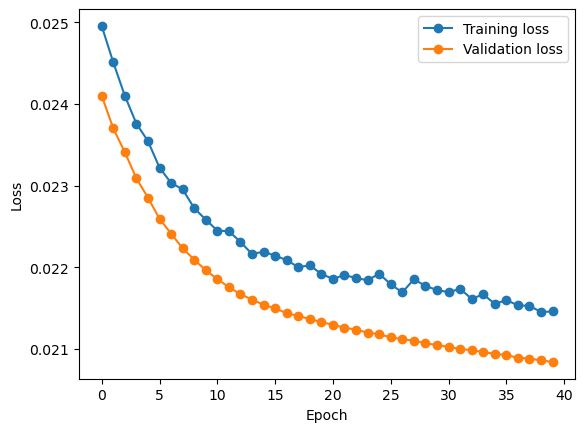

In [26]:
import matplotlib.pyplot as plt

# Assuming you have already stored the training and validation losses in lists named train_losses and val_losses

# Define the range of epochs you want to plot
start_epoch = 0
end_epoch = 40

# Slice the lists to get losses for the desired epochs
train_losses_to_plot = train_loss[start_epoch:end_epoch]
val_losses_to_plot = val_loss[start_epoch:end_epoch]

# Plotting the losses
plt.plot(train_losses_to_plot, label='Training loss',  marker='o')
plt.plot(val_losses_to_plot, label='Validation loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


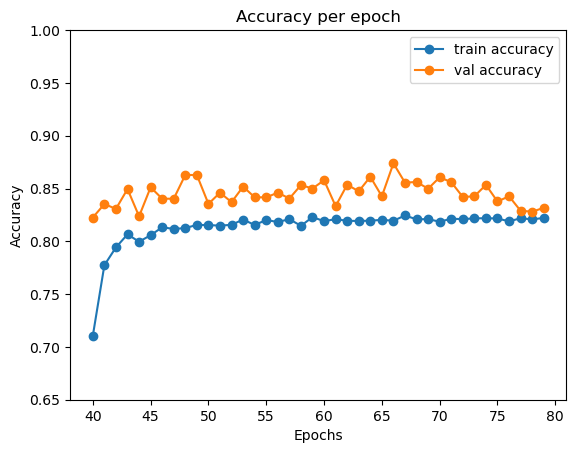

In [31]:
import matplotlib.pyplot as plt

# Move tensors to CPU and extract values for plotting
train_acc_cpu = [acc.cpu().item() for acc in train_acc]
val_acc_cpu = [acc.cpu().item() for acc in val_acc]

fig_acc, ax_acc = plt.subplots()
ax_acc.plot(train_acc_cpu[40:81], label='train accuracy', marker='o')
ax_acc.plot(val_acc_cpu[40:81], label='val accuracy', marker='o')
ax_acc.legend()
ax_acc.set_title('Accuracy per epoch')
ax_acc.set_xlabel('Epochs')
ax_acc.set_ylabel('Accuracy')

# Set x-axis ticks and labels
num_epochs = len(train_acc_cpu[40:81])
ax_acc.set_xticks(range(0, num_epochs + 1, 5))  # Set ticks at intervals of 5
ax_acc.set_xticklabels(range(40, 81, 5))  # Set labels corresponding to the ticks

# Customize y-axis limits from 70 to 100
ax_acc.set_ylim(0.65, 1)

plt.show()  # Display the accuracy plot


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:08<00:00, 11.05it/s]


test loss: 0.327052 acc: 0.868627


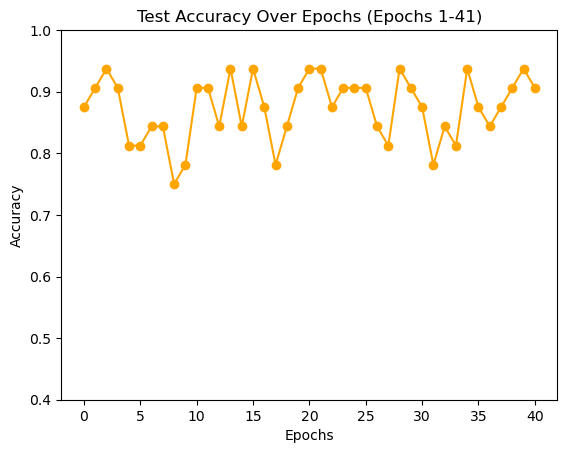

In [32]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

#plt.figure(figsize=(18, 6))

running_loss = 0.0
running_correct = 0
test_accuracy = []

model.eval()
# Iterate over batches
for inputs, labels in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

    running_loss += loss.item() * inputs.size(0)
    running_correct += torch.sum(preds == labels.data)
    
    # Calculate accuracy and store it
    accuracy = torch.sum(preds == labels.data).double() / labels.size(0)
    test_accuracy.append(accuracy.item())

epoch_loss = running_loss / test_len
epoch_acc = running_correct.double() / test_len

print('{} loss: {:4f} acc: {:4f}'.format('test', epoch_loss, epoch_acc))

# Plotting
plt.plot(test_accuracy[:41], color='orange', marker='o')  # Set marker as 'o' and color as orange
plt.title('Test Accuracy Over Epochs (Epochs 1-41)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.4, 1)  # Set the y-axis limits
plt.show()


In [41]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have validation_loader defined and it yields batches of data
# Use the model to get predictions on the validation set
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[1489   69]
 [ 333 1169]]


In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision
precision = precision_score(true_labels, predicted_labels)

# Calculate recall
recall = recall_score(true_labels, predicted_labels)

# Calculate F1-score
f1score = f1_score(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1score)


Accuracy: 0.8686274509803922
Precision: 0.944264943457189
Recall: 0.7782956058588548
F1-score: 0.8532846715328467
